## benchmarking on sushmita ROY's dataset


In [1]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer

from bengrn import BenGRN, get_sroy_gt
import scanpy as sc
from bengrn.base import train_classifier

from anndata.utils import make_index_unique
from bengrn import compute_genie3
from grnndata import utils as grnutils

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


2024-05-28 14:28:03,678:INFO - Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
2024-05-28 14:28:03,774:INFO - Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
2024-05-28 14:28:03,855:INFO - Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
2024-05-28 14:28:03,929:INFO - Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
2024-05-28 14:28:04,011:INFO - Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
2024-05-28 14:28:04,202:INFO - Downloading data from `https://omnipathdb.org/about?format=text`
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core

In [2]:
# '../../data/main/gene_embeddings.parquet')
model = scPrint.load_from_checkpoint(
    '../data/temp/vbd8bavn/epoch=17-step=90000.ckpt', precpt_gene_emb=None)

MAXGENES = 5000

RuntimeError caught: scPrint is not attached to a `Trainer`.



In [3]:
preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)

# liu / full


In [4]:
preadata = get_sroy_gt(get="liu", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 72 renamining
filtered out 0 cells, 72 renamining
Removed 0 genes.
startin QC
Seeing 4 outliers (5.56% of total dataset):
done


(GRnnData object with n_obs × n_vars = 72 × 23153
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 10537 elements,
 33)

/tmp/ipykernel_1451034/1079860506.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 16947


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical
/home/ml4ig1/Documents code/benGRN/bengrn/base.py:270: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(genes), len(genes)), dtype=np.float)


true elem 11725 ...
doing regression....
metrics {'used_heads': 26, 'precision': 0.003257328990228013, 'random_precision': 0.0010413009987395255, 'recall': 0.0026200873362445414, 'predicted_true': 921.0, 'number_of_true': 1145.0, 'epr': 2.5241434359482398}


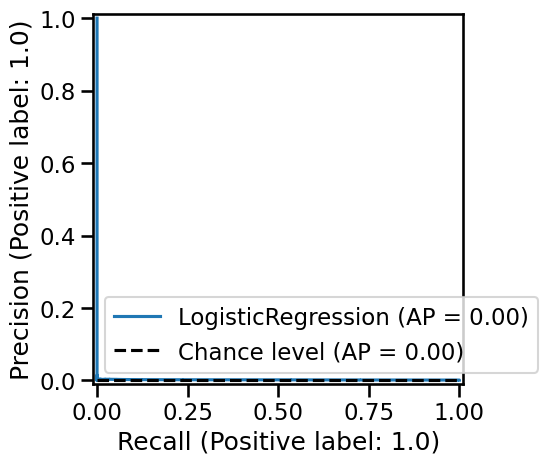

precision:  0.030952717468117723 
recall:  1.0 
random precision: 0.030952717468117723


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:675: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 1116.70it/s]


Area Under Precision-Recall Curve (AUPRC):  0.03701342905613458
EPR: 1.7165712159921016


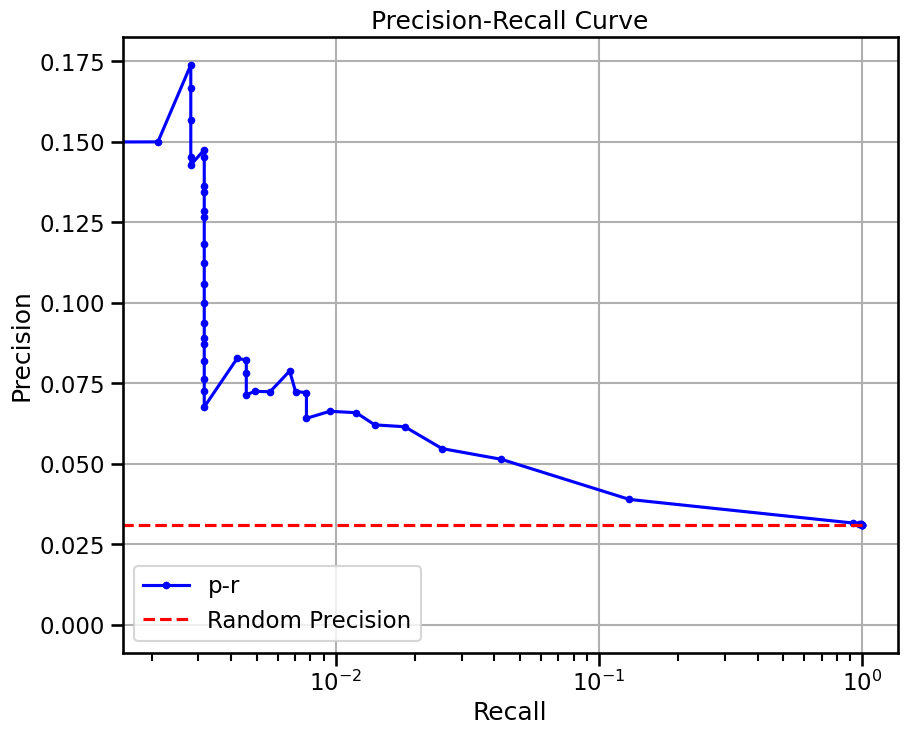

pred shape (19, 4842, 32)
true elem 2847 ...
doing regression....
metrics {'used_heads': 1, 'precision': 0.030264445100079192, 'random_precision': 0.030264445100079192, 'recall': 1.0, 'predicted_true': 64399.0, 'number_of_true': 1949.0, 'epr': 1.406289977944784}


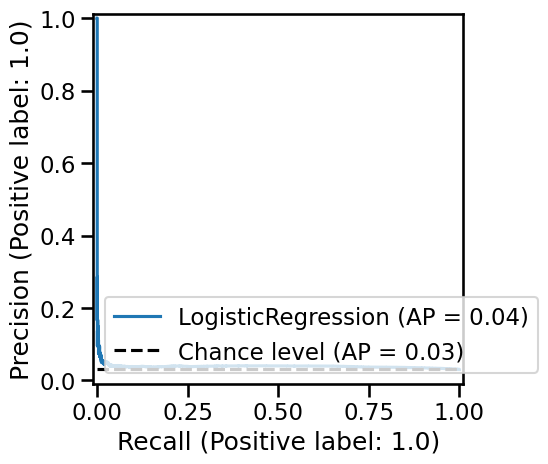

precision:  0.03094632492010696 
recall:  1.0 
random precision: 0.030952717468117723


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 1838.80it/s]


Area Under Precision-Recall Curve (AUPRC):  0.056546482999774446
EPR: 1.5217846872341962


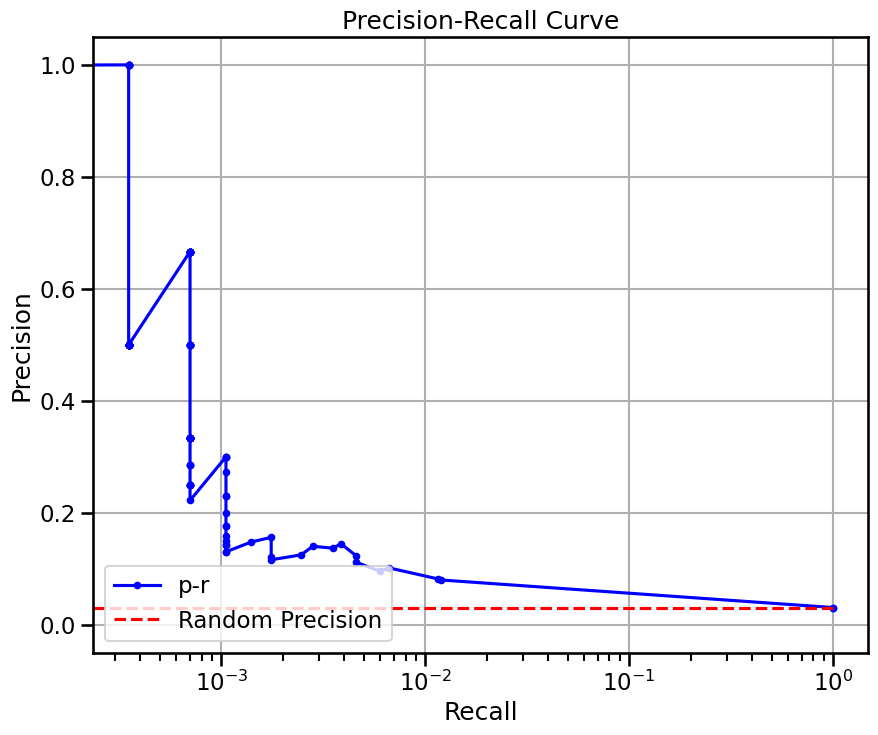

{'precision': 0.03094632492010696,
 'recall': 1.0,
 'rand_precision': 0.030952717468117723,
 'auprc': 0.056546482999774446,
 'EPR': 1.5217846872341962}

In [7]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn, m, clf_omni = train_classifier(grn, C=1, train_size=0.9, class_weight={
                                    1: 200, 0: 1}, shuffle=True)
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, clf_self = train_classifier(
    grn, other=preadata, C=0.1, train_size=0.3, class_weight={1: 100, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

/tmp/ipykernel_2253230/3429280539.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 16947


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical
/home/ml4ig1/Documents code/benGRN/bengrn/base.py:278: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(genes), len(genes)), dtype=np.float)


true elem 11725 ...
doing regression....
metrics {'used_heads': 26, 'precision': 0.003257328990228013, 'random_precision': 0.0010413009987395255, 'recall': 0.0026200873362445414, 'predicted_true': 921.0, 'number_of_true': 1145.0, 'epr': 2.5241434359482398}


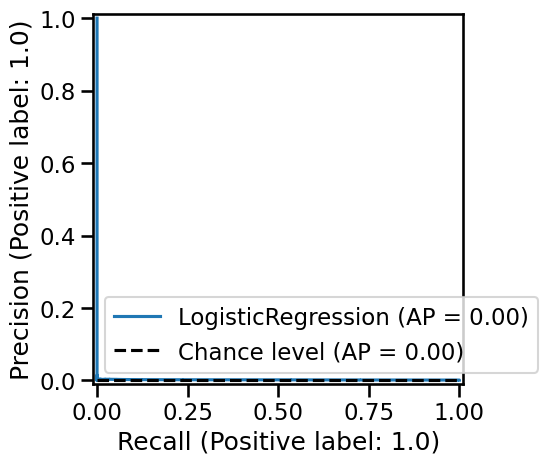

base enrichment
Top central genes: []


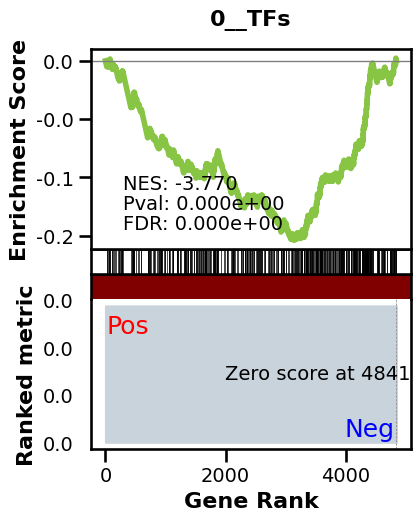

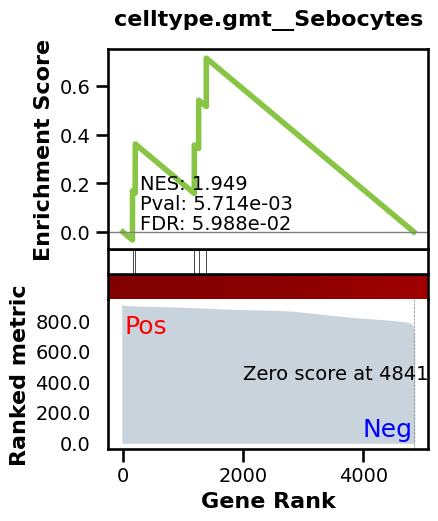

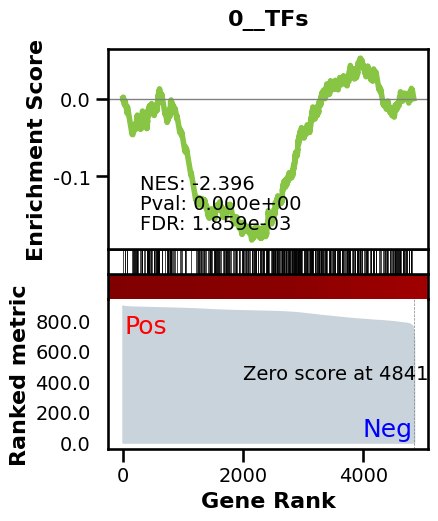

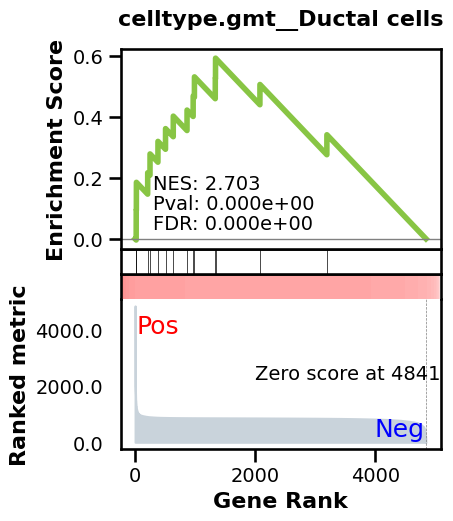

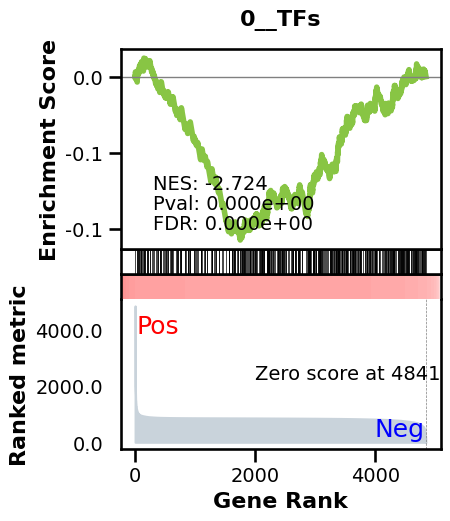

_________________________________________
TF specific enrichment


2024-05-27 12:13:14,122:INFO - Downloading and generating Enrichr library gene sets...
2024-05-27 12:13:14,128:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-27 12:13:14,341:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  25.53191489361702 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 3316 genes
intersection pct: 0.6848409748038001
precision:  0.0010666133466124043 
recall:  1.0 
random precision: 0.0010666324616512653


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:678: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 46%|████▋     | 46/99 [00:00<00:01, 49.69it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:684: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:02<00:00, 45.94it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0016452203425846809
EPR: 1.9228120408753853


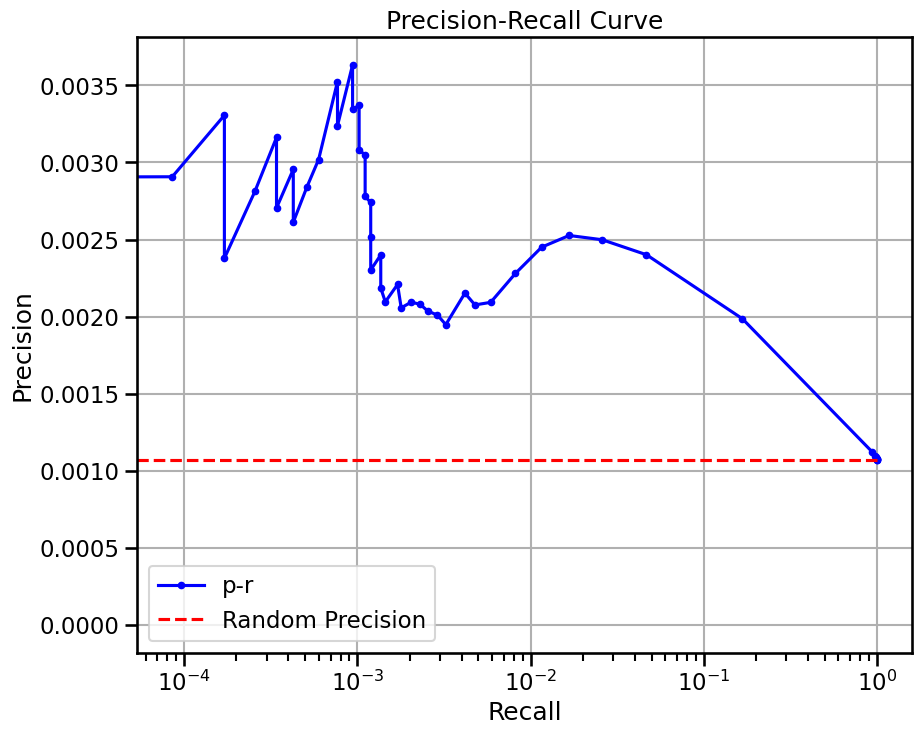

{'TF_enr': True,
 'enriched_terms_Targets': ['celltype.gmt__Sebocytes'],
 'enriched_terms_Regulators': ['celltype.gmt__Ductal cells',
  'celltype.gmt__Enterocytes',
  'celltype.gmt__Hepatocytes',
  'celltype.gmt__Myoblasts',
  'celltype.gmt__Enteric glia cells',
  'celltype.gmt__Merkel cells',
  'celltype.gmt__Podocytes',
  'celltype.gmt__Radial glial cells',
  'celltype.gmt__Delta cells',
  'celltype.gmt__Fibroblasts',
  'celltype.gmt__Mature neurons',
  'celltype.gmt__Cholangiocytes',
  'celltype.gmt__Pre-B cells',
  'celltype.gmt__Myofibroblasts',
  'celltype.gmt__Adipocytes',
  'celltype.gmt__Beta cells',
  'celltype.gmt__Neural stem cells',
  'celltype.gmt__Clara cells',
  'celltype.gmt__Epsilon cells',
  'celltype.gmt__Embryonic stem cells',
  'celltype.gmt__Trophoblast cells',
  'celltype.gmt__Hepatic stellate cells',
  'celltype.gmt__Alpha cells',
  'celltype.gmt__ISG expressing immune cells',
  'celltype.gmt__Gamma (PP) cells',
  'celltype.gmt__HSC/MPP cells',
  'celltype.gmt_

In [8]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn, m, clf_omni = train_classifier(grn, C=1, train_size=0.9, class_weight={
                                    1: 200, 0: 1}, shuffle=True)
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

/tmp/ipykernel_1451034/590398501.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 16947


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 23522500, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.03094632492010696 
recall:  1.0 
random precision: 0.030952717468117723


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 2112.88it/s]


Area Under Precision-Recall Curve (AUPRC):  0.03150938084632847
EPR: 1.0227206797377573


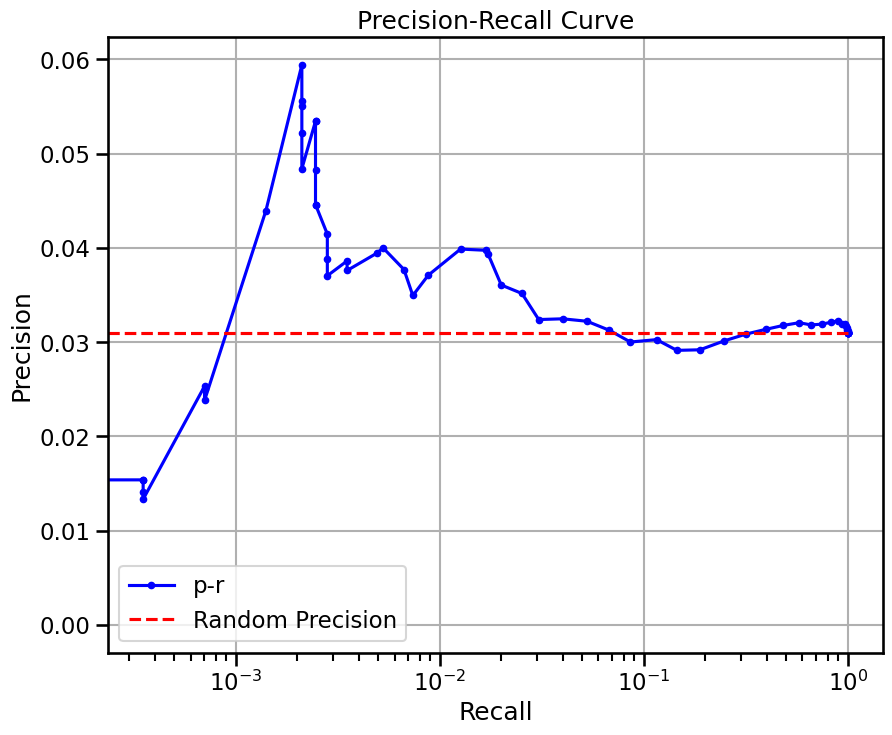

{'precision': 0.03094632492010696,
 'recall': 1.0,
 'rand_precision': 0.030952717468117723,
 'auprc': 0.03150938084632847,
 'EPR': 1.0227206797377573}

In [8]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
BenGRN(grn, do_auc=True, doplot=True)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 16947


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 23522500, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.03094632492010696 
recall:  1.0 
random precision: 0.030952717468117723


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:684: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 2178.78it/s]


Area Under Precision-Recall Curve (AUPRC):  0.03279408410558371
EPR: 0.866670228987736


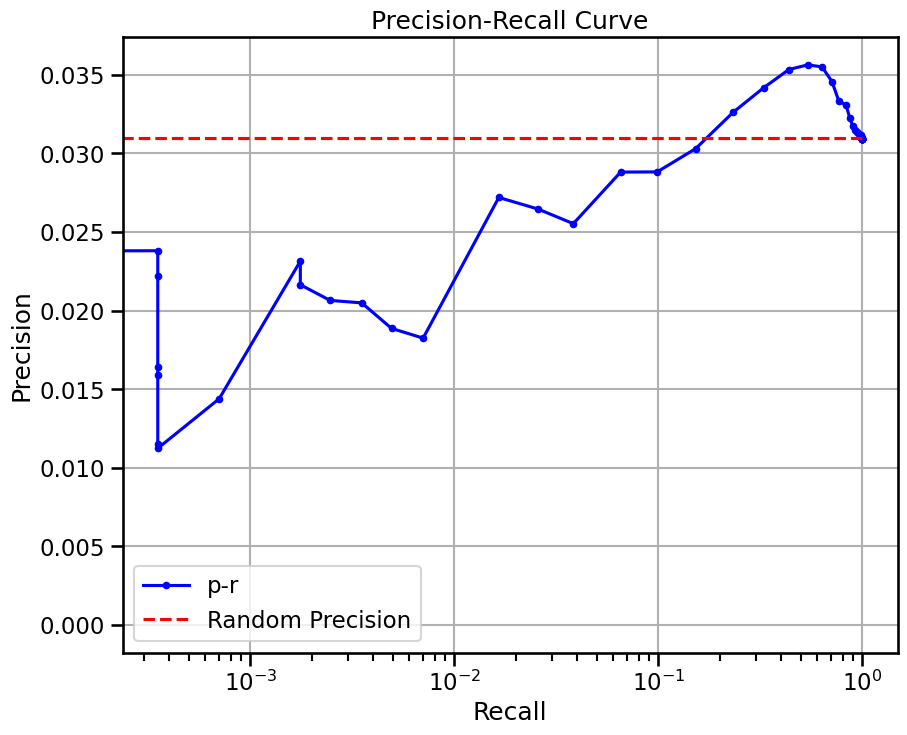

{'precision': 0.03094632492010696,
 'recall': 1.0,
 'rand_precision': 0.030952717468117723,
 'auprc': 0.03279408410558371,
 'EPR': 0.866670228987736}

In [7]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='mean',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=100,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[-2:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
#BenGRN(grn, do_auc=True, doplot=True)

# liu / chip


In [4]:
preadata = get_sroy_gt(get="liu", species="human", gt="chip")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 72 renamining
filtered out 0 cells, 72 renamining
Removed 0 genes.
startin QC
Seeing 4 outliers (5.56% of total dataset):
done


(GRnnData object with n_obs × n_vars = 72 × 23153
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 435395 elements,
 90)

/tmp/ipykernel_1455512/3297281218.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 16947


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical
/home/ml4ig1/Documents code/benGRN/bengrn/base.py:270: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(genes), len(genes)), dtype=np.float)


true elem 11725 ...
doing regression....
metrics {'used_heads': 26, 'precision': 0.003257328990228013, 'random_precision': 0.0010413009987395255, 'recall': 0.0026200873362445414, 'predicted_true': 921.0, 'number_of_true': 1145.0, 'epr': 2.5241434359482398}


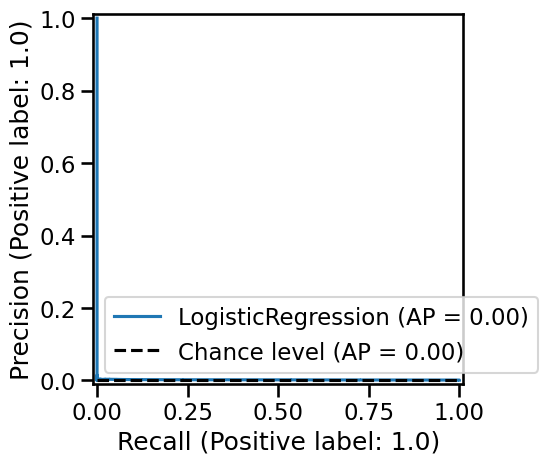

precision:  0.2787887394860341 
recall:  0.9999768459561462 
random precision: 0.27879699442263994


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:675: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 26%|██▋       | 26/99 [00:00<00:00, 257.16it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 432.03it/s]


Area Under Precision-Recall Curve (AUPRC):  0.29922428711788013
EPR: 1.2241638970691204


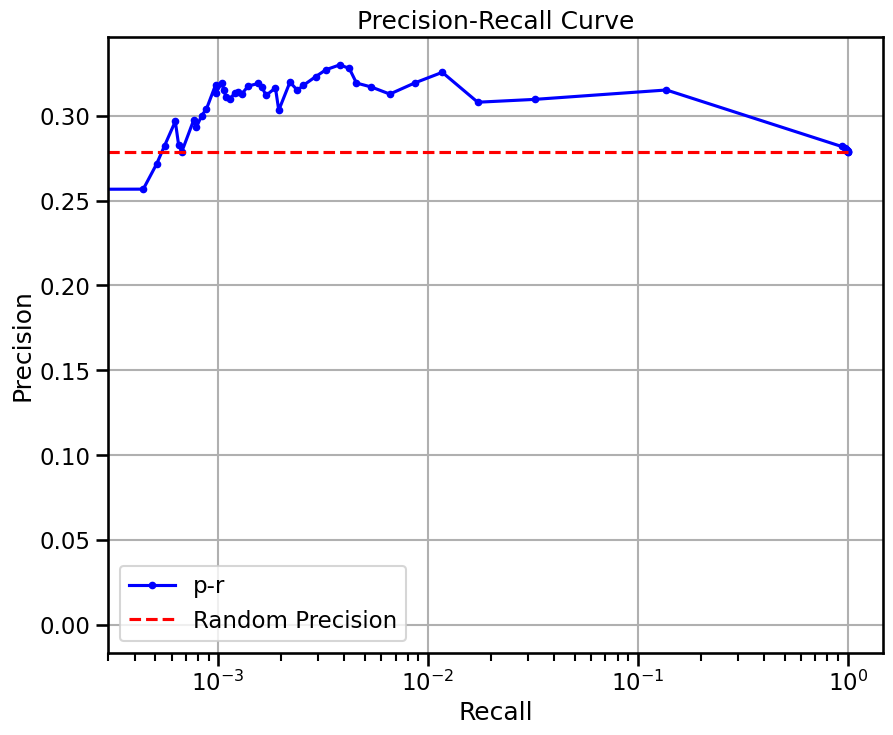

pred shape (32, 4842, 32)
true elem 43189 ...
doing regression....
metrics {'used_heads': 7, 'precision': 0.30987539314339474, 'random_precision': 0.30977033219313854, 'recall': 0.9999702363235907, 'predicted_true': 108421.0, 'number_of_true': 33598.0, 'epr': 1.525671951322129}


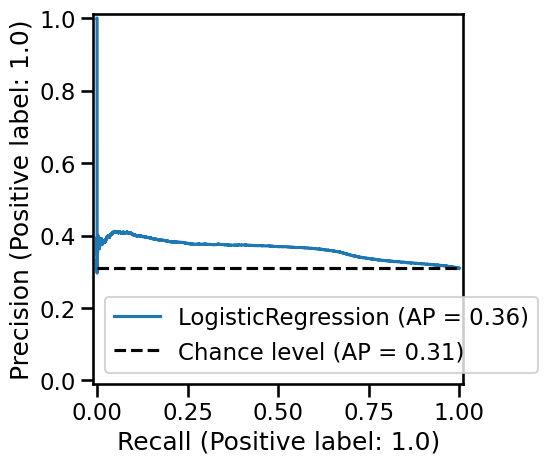

precision:  0.2787394155307724 
recall:  1.0 
random precision: 0.27879699442263994


 92%|█████████▏| 91/99 [00:00<00:00, 482.90it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 458.76it/s]


Area Under Precision-Recall Curve (AUPRC):  0.2972235127368131
EPR: 1.6116498052658546


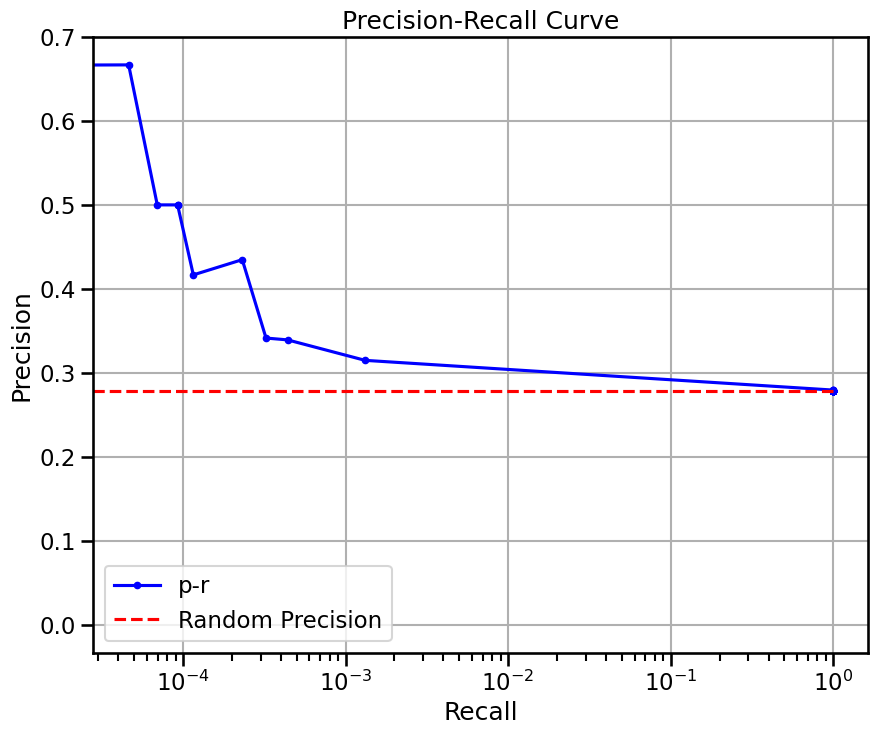

{'precision': 0.2787394155307724,
 'recall': 1.0,
 'rand_precision': 0.27879699442263994,
 'auprc': 0.2972235127368131,
 'EPR': 1.6116498052658546}

In [5]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
# grn.varp["classified"] = clf_omni.predict_proba(
#    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
# ).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn, m, clf_omni2 = train_classifier(grn, C=1, train_size=0.9, class_weight={
    1: 200, 0: 1}, shuffle=True)
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.5, train_size=0.3, class_weight={
                             1: 10, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

/tmp/ipykernel_1455512/590398501.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 16947


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 23522500, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.2787394155307724 
recall:  1.0 
random precision: 0.27879699442263994


 67%|██████▋   | 66/99 [00:00<00:00, 655.05it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 677.57it/s]


Area Under Precision-Recall Curve (AUPRC):  0.2813312425452778
EPR: 1.0379366039470581


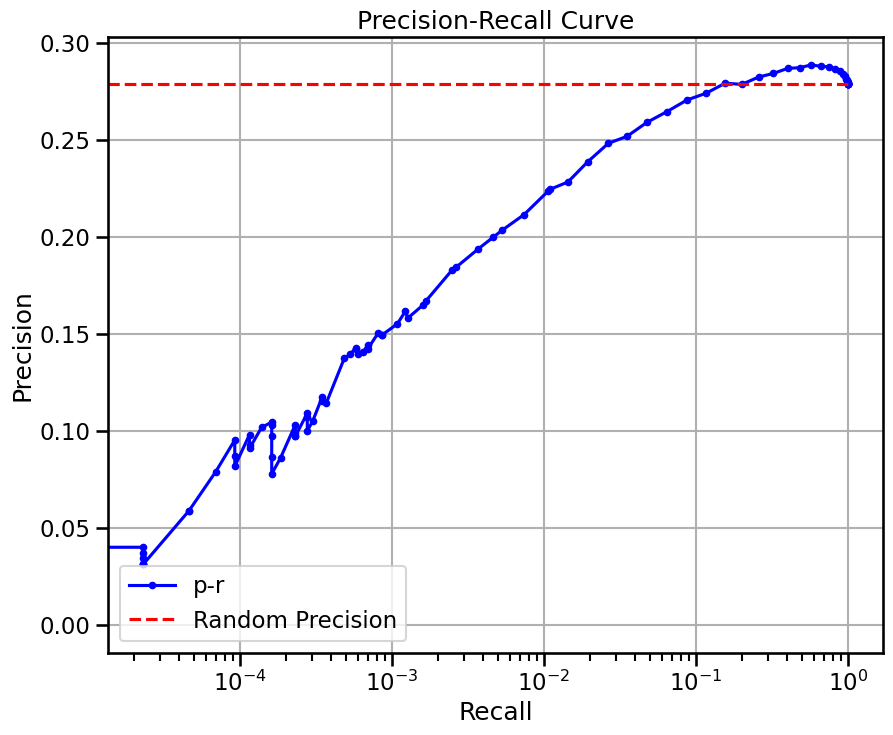

{'precision': 0.2787394155307724,
 'recall': 1.0,
 'rand_precision': 0.27879699442263994,
 'auprc': 0.2813312425452778,
 'EPR': 1.0379366039470581}

In [6]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## liu / ko


In [4]:
preadata = get_sroy_gt(get="liu", species="human", gt="ko")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 72 renamining
filtered out 0 cells, 72 renamining
Removed 0 genes.
startin QC
Seeing 4 outliers (5.56% of total dataset):
done


(GRnnData object with n_obs × n_vars = 72 × 23153
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 108194 elements,
 157)

/tmp/ipykernel_1486605/3217281525.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 16947


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical
/home/ml4ig1/Documents code/benGRN/bengrn/base.py:270: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(genes), len(genes)), dtype=np.float)


true elem 11725 ...
doing regression....
metrics {'used_heads': 26, 'precision': 0.003257328990228013, 'random_precision': 0.0010413009987395255, 'recall': 0.0026200873362445414, 'predicted_true': 921.0, 'number_of_true': 1145.0, 'epr': 2.5241434359482398}


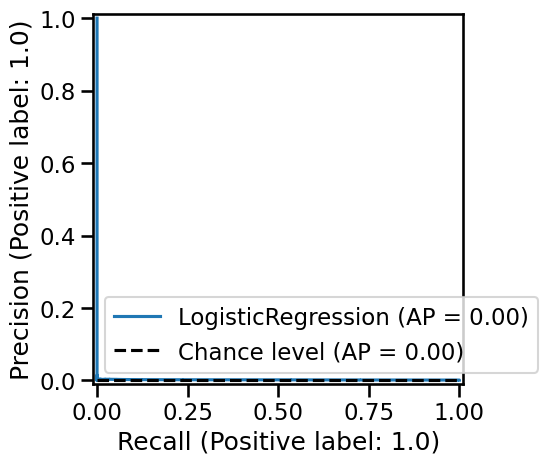

precision:  0.05675878689242903 
recall:  1.0 
random precision: 0.05675949747422584


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:675: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 597.44it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0673361420855374
EPR: 1.3307970484146516


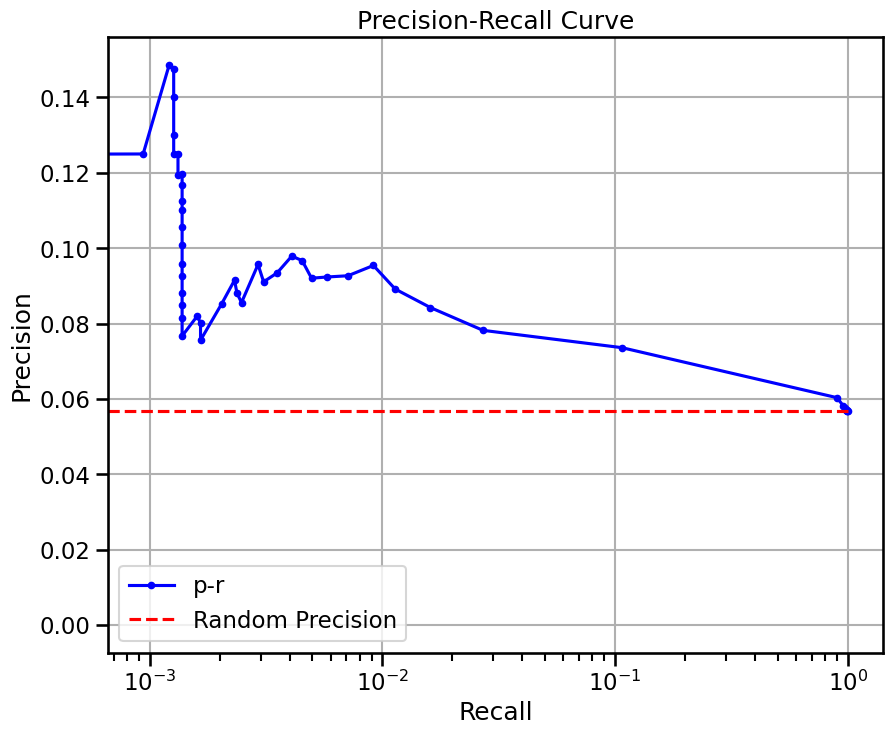

pred shape (66, 4842, 32)
true elem 18135 ...
doing regression....
metrics {'used_heads': 2, 'precision': 0.0, 'random_precision': 0.05822951171429721, 'recall': 0.0, 'predicted_true': 4.0, 'number_of_true': 13026.0, 'epr': 0.925551074793662}


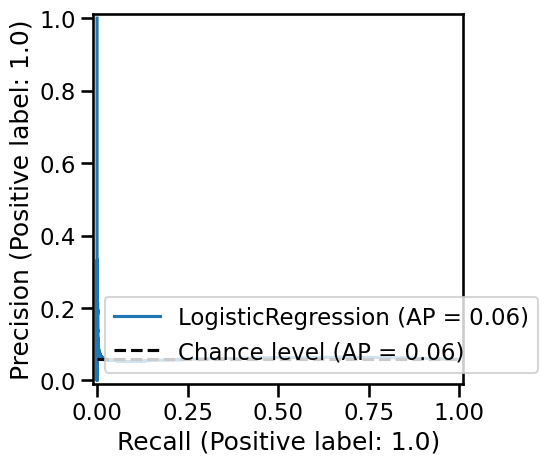

precision:  0.05674777514926214 
recall:  1.0 
random precision: 0.05675949747422584


 48%|████▊     | 48/99 [00:00<00:00, 477.12it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 590.59it/s]


Area Under Precision-Recall Curve (AUPRC):  0.05383092843539151
EPR: 0.8534768392694666


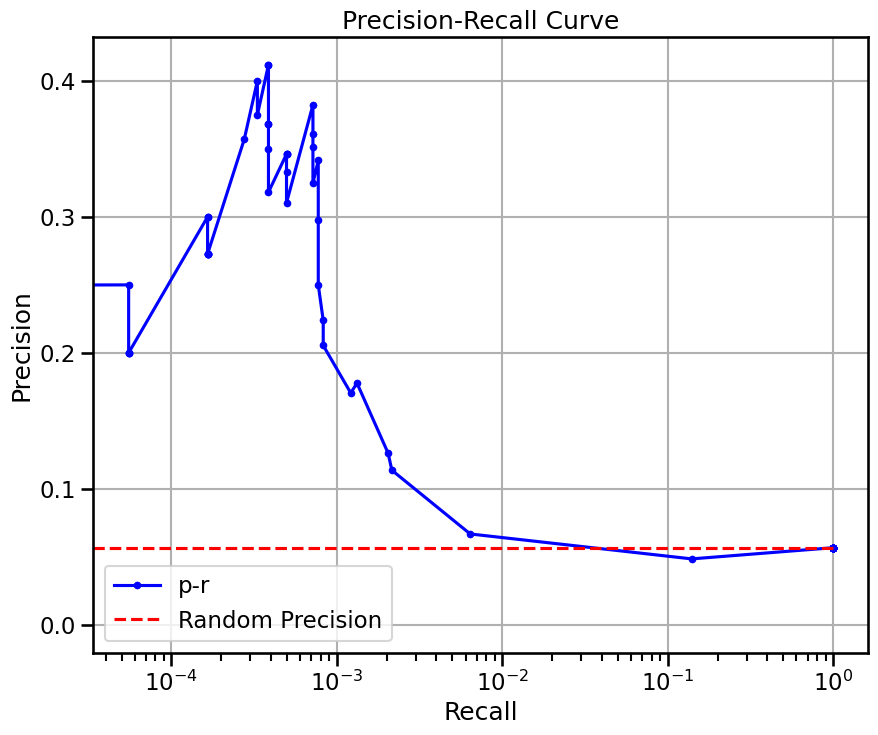

{'precision': 0.05674777514926214,
 'recall': 1.0,
 'rand_precision': 0.05675949747422584,
 'auprc': 0.05383092843539151,
 'EPR': 0.8534768392694666}

In [5]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
# grn.varp["classified"] = clf_omni.predict_proba(
#    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
# ).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn, m, clf_omni = train_classifier(grn, C=1, train_size=0.9, class_weight={
                                    1: 200, 0: 1}, shuffle=True)
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.2, train_size=0.3, class_weight={
                             1: 10, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

pred shape (66, 4842, 32)
true elem 18135 ...
doing regression....
metrics {'used_heads': 17, 'precision': 0.058875611456129004, 'random_precision': 0.058753582917151694, 'recall': 0.9987217724755006, 'predicted_true': 159251.0, 'number_of_true': 9388.0, 'epr': 1.1190480067552397}


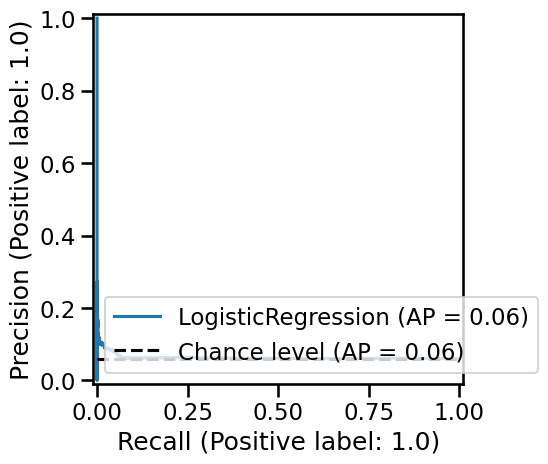

precision:  0.05674777514926214 
recall:  1.0 
random precision: 0.05675949747422584


 54%|█████▎    | 53/99 [00:00<00:00, 529.59it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 608.01it/s]


Area Under Precision-Recall Curve (AUPRC):  0.08369191716921298
EPR: 1.6171541123236626


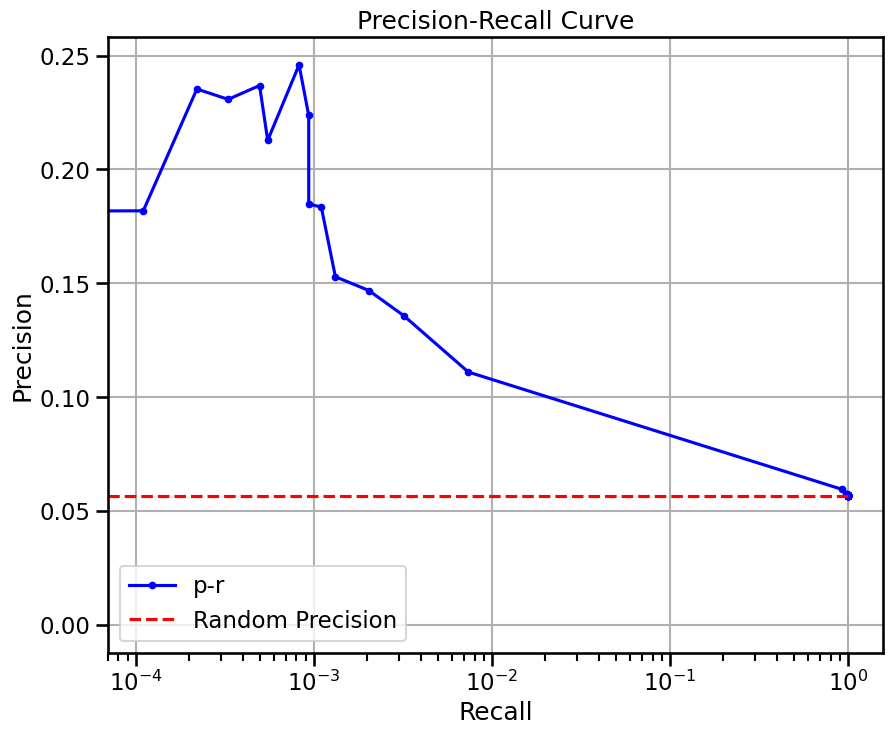

{'precision': 0.05674777514926214,
 'recall': 1.0,
 'rand_precision': 0.05675949747422584,
 'auprc': 0.08369191716921298,
 'EPR': 1.6171541123236626}

In [7]:
grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.5, train_size=0.5, class_weight={
                             1: 40, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

/tmp/ipykernel_1455512/590398501.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 16947


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 23522500, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.05674777514926214 
recall:  1.0 
random precision: 0.05675949747422584


 78%|███████▊  | 77/99 [00:00<00:00, 762.66it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 770.33it/s]


Area Under Precision-Recall Curve (AUPRC):  0.05465983575349624
EPR: 0.9227536728273664


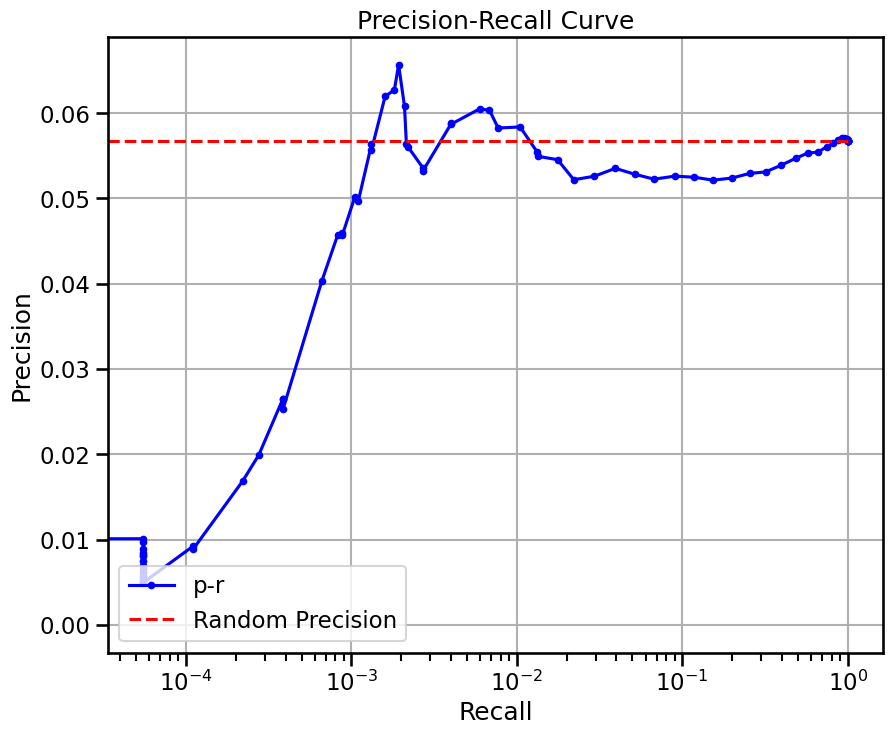

{'precision': 0.05674777514926214,
 'recall': 1.0,
 'rand_precision': 0.05675949747422584,
 'auprc': 0.05465983575349624,
 'EPR': 0.9227536728273664}

In [9]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

# chen / all


In [11]:
preadata = get_sroy_gt(get="chen", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 385 renamining
filtered out 0 cells, 385 renamining
Removed 0 genes.
startin QC
Seeing 38 outliers (9.87% of total dataset):
done


(GRnnData object with n_obs × n_vars = 385 × 8595
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 2969 elements,
 19)

/tmp/ipykernel_1455512/1308650287.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7906


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.017410924132744195 
recall:  1.0 
random precision: 0.01741452589611464


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 4640.18it/s]


Area Under Precision-Recall Curve (AUPRC):  0.025759130607077397
EPR: 1.7829772669778423


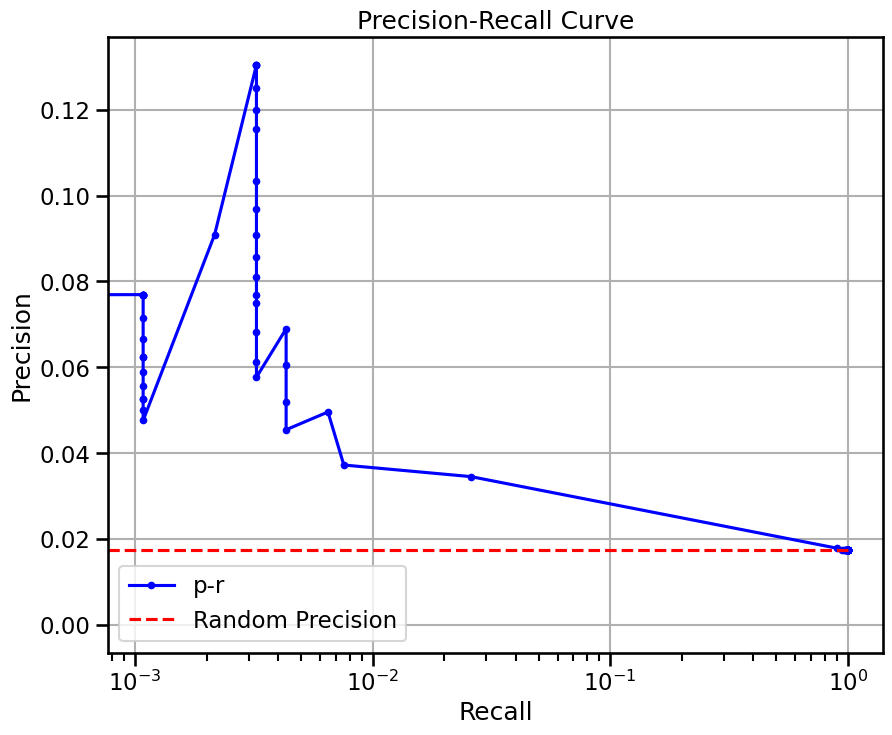

pred shape (11, 4835, 32)
true elem 926 ...
doing regression....
metrics {'used_heads': 1, 'precision': 0.00394842868654311, 'random_precision': 0.00394842868654311, 'recall': 1.0, 'predicted_true': 37230.0, 'number_of_true': 147.0, 'epr': 1.7328297992118595}


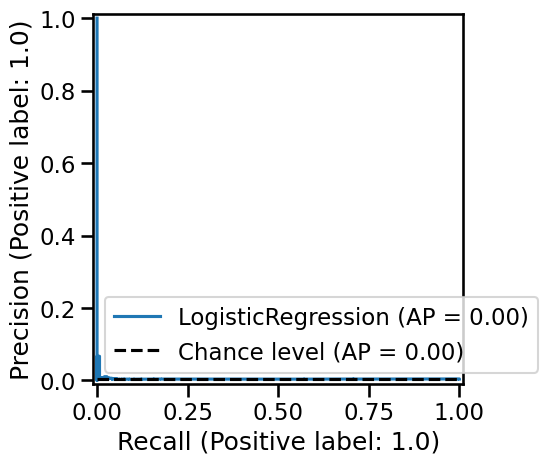

precision:  0.017410924132744195 
recall:  1.0 
random precision: 0.01741452589611464


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 4390.27it/s]


Area Under Precision-Recall Curve (AUPRC):  0.1088814022220448
EPR: 1.3164469949024755


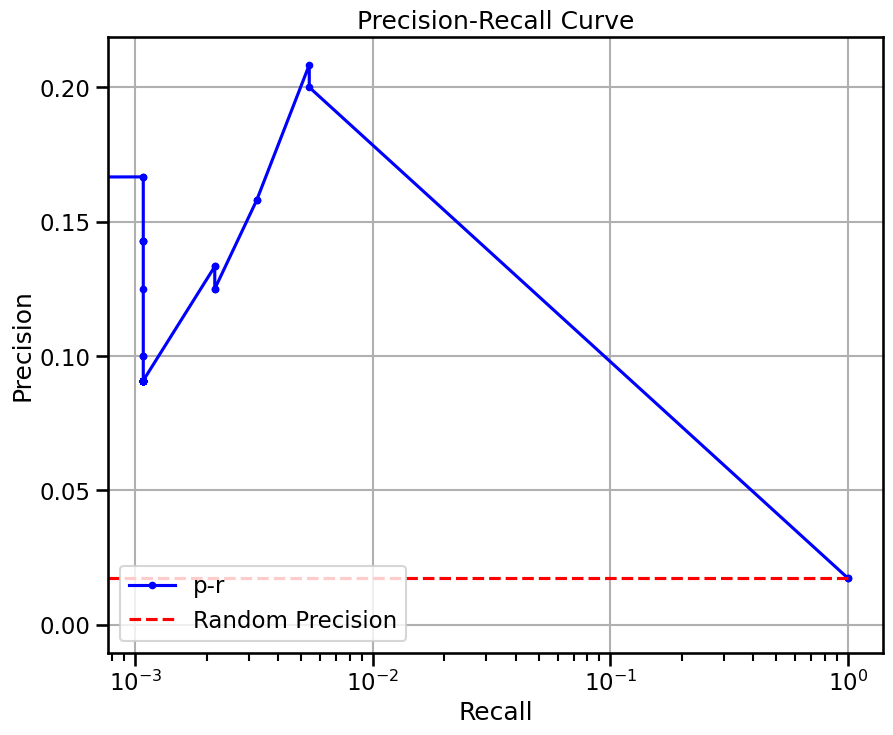

{'precision': 0.017410924132744195,
 'recall': 1.0,
 'rand_precision': 0.01741452589611464,
 'auprc': 0.1088814022220448,
 'EPR': 1.3164469949024755}

In [12]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.varp["classified"] = clf_omni.predict_proba(
    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.1, train_size=0.3, class_weight={
                             1: 100, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

/tmp/ipykernel_1455512/590398501.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7906


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 23454649, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.017410924132744195 
recall:  1.0 
random precision: 0.01741452589611464


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 4329.34it/s]


Area Under Precision-Recall Curve (AUPRC):  0.017804259480311467
EPR: 1.12087368278057


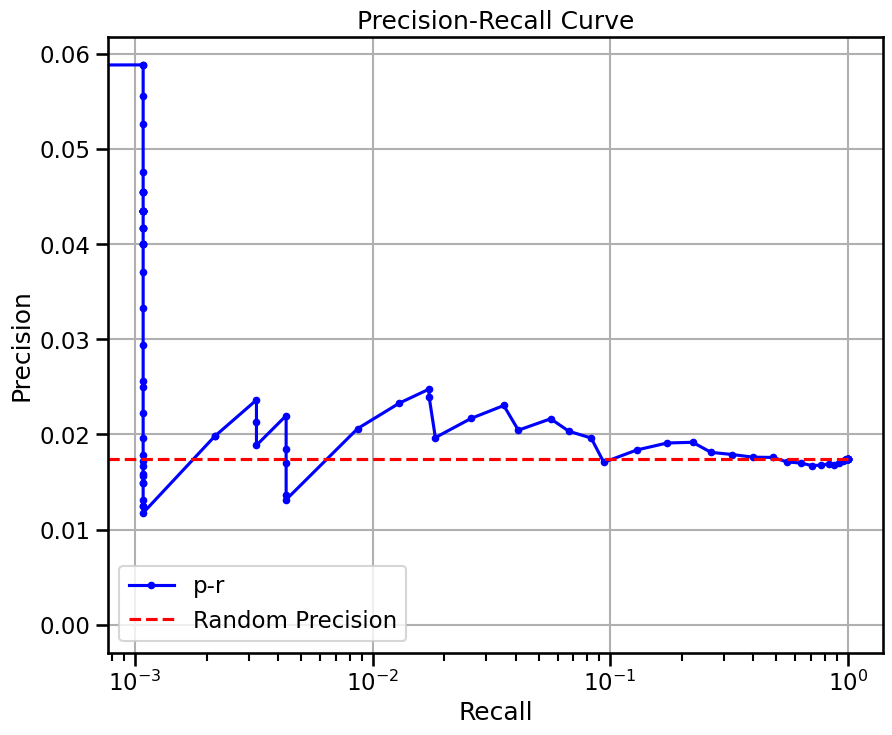

{'precision': 0.017410924132744195,
 'recall': 1.0,
 'rand_precision': 0.01741452589611464,
 'auprc': 0.017804259480311467,
 'EPR': 1.12087368278057}

In [13]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

# Duren / all


In [10]:
preadata = get_sroy_gt(get="duren", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 464 renamining
filtered out 0 cells, 464 renamining
Removed 0 genes.
startin QC
Seeing 22 outliers (4.74% of total dataset):
done


(GRnnData object with n_obs × n_vars = 464 × 15299
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 7466 elements,
 44)

/tmp/ipykernel_1486605/1583948291.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 14620


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.006052861658484094 
recall:  1.0 
random precision: 0.006053268765133172


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:675: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 3413.59it/s]


Area Under Precision-Recall Curve (AUPRC):  0.006852799182253582
EPR: 1.8544375710137608


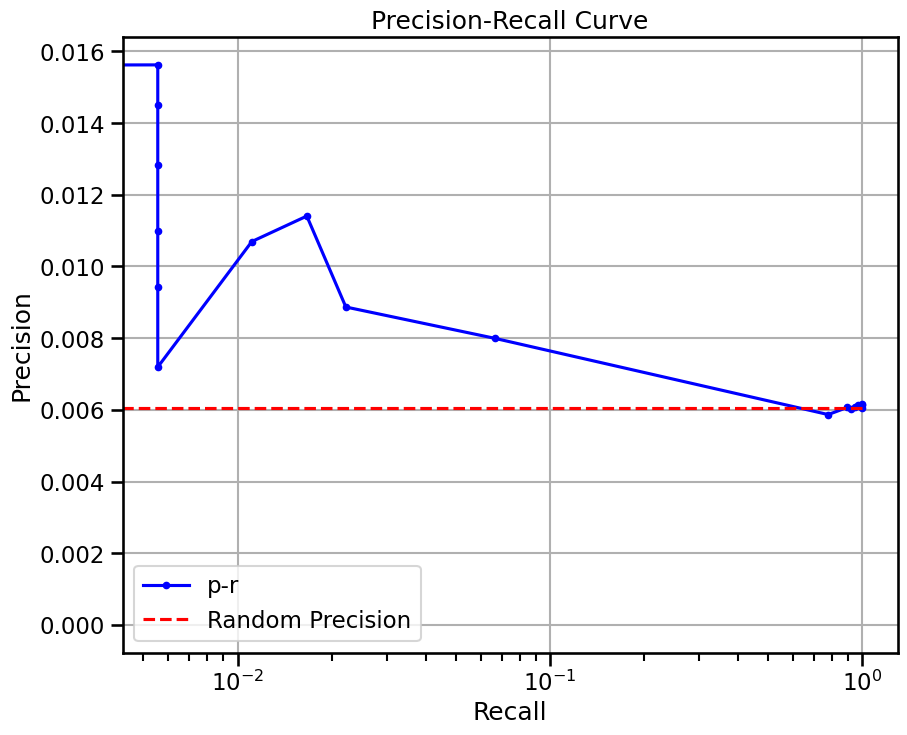

pred shape (6, 4957, 32)
true elem 180 ...
doing regression....


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:296: RuntimeWarning: invalid value encountered in long_scalars
  "precision": (pred[y_test == 1] == 1).sum() / (pred == 1).sum(),


metrics {'used_heads': 0, 'precision': nan, 'random_precision': 0.004101943379732365, 'recall': 0.0, 'predicted_true': 0.0, 'number_of_true': 61.0, 'epr': 0.0}


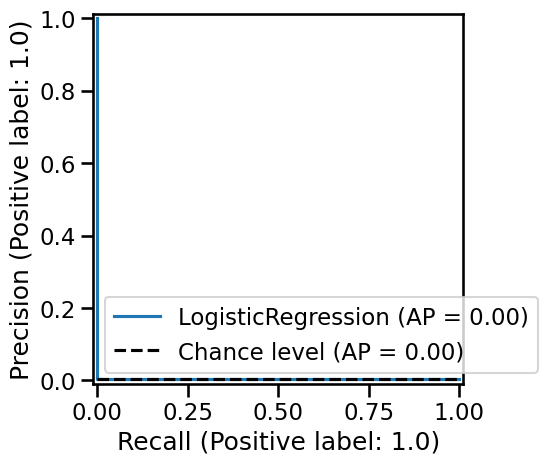

precision:  0.006052047609441194 
recall:  1.0 
random precision: 0.006053268765133172


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 3504.34it/s]


Area Under Precision-Recall Curve (AUPRC):  0.003026023804720597
EPR: 1.8544375710137608


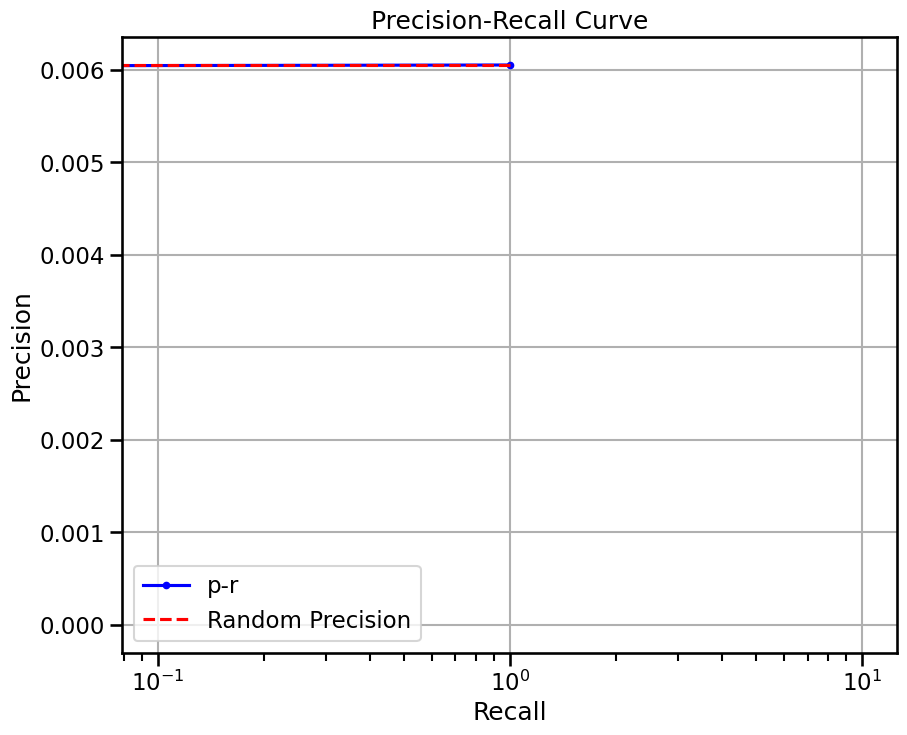

{'precision': 0.006052047609441194,
 'recall': 1.0,
 'rand_precision': 0.006053268765133172,
 'auprc': 0.003026023804720597,
 'EPR': 1.8544375710137608}

In [9]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.varp["classified"] = clf_omni.predict_proba(
    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.5, train_size=0.5, class_weight={
                             1: 40, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

pred shape (6, 4957, 32)
true elem 180 ...
doing regression....
metrics {'used_heads': 1, 'precision': 0.0, 'random_precision': 0.00611929258287943, 'recall': 0.0, 'predicted_true': 6.0, 'number_of_true': 91.0, 'epr': 0.0}


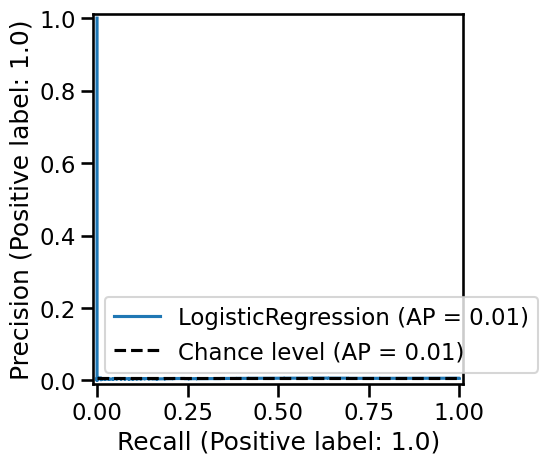

precision:  0.006052047609441194 
recall:  1.0 
random precision: 0.006053268765133172


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 6180.49it/s]


Area Under Precision-Recall Curve (AUPRC):  0.006709831498733423
EPR: 1.8544375710137608


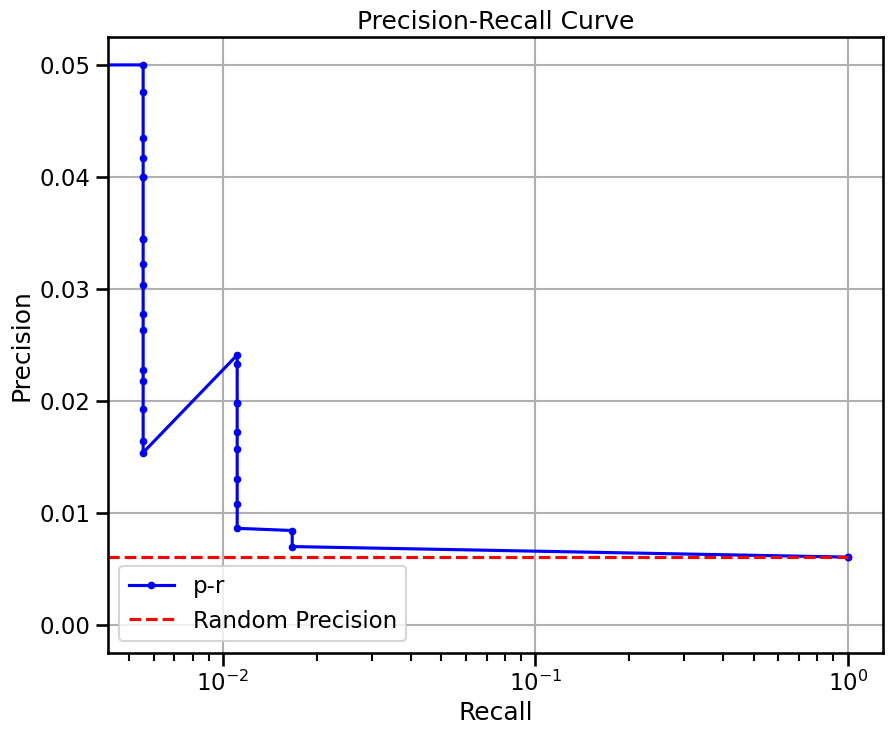

{'precision': 0.006052047609441194,
 'recall': 1.0,
 'rand_precision': 0.006053268765133172,
 'auprc': 0.006709831498733423,
 'EPR': 1.8544375710137608}

In [12]:
grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.5, train_size=0.5, class_weight={
                             1: 100, 0: 1}, shuffle=True)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

/tmp/ipykernel_1455512/590398501.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 14620


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 24651225, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.006052047609441194 
recall:  1.0 
random precision: 0.006053268765133172


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 9102.26it/s]


Area Under Precision-Recall Curve (AUPRC):  0.005705009776771963
EPR: 0.0


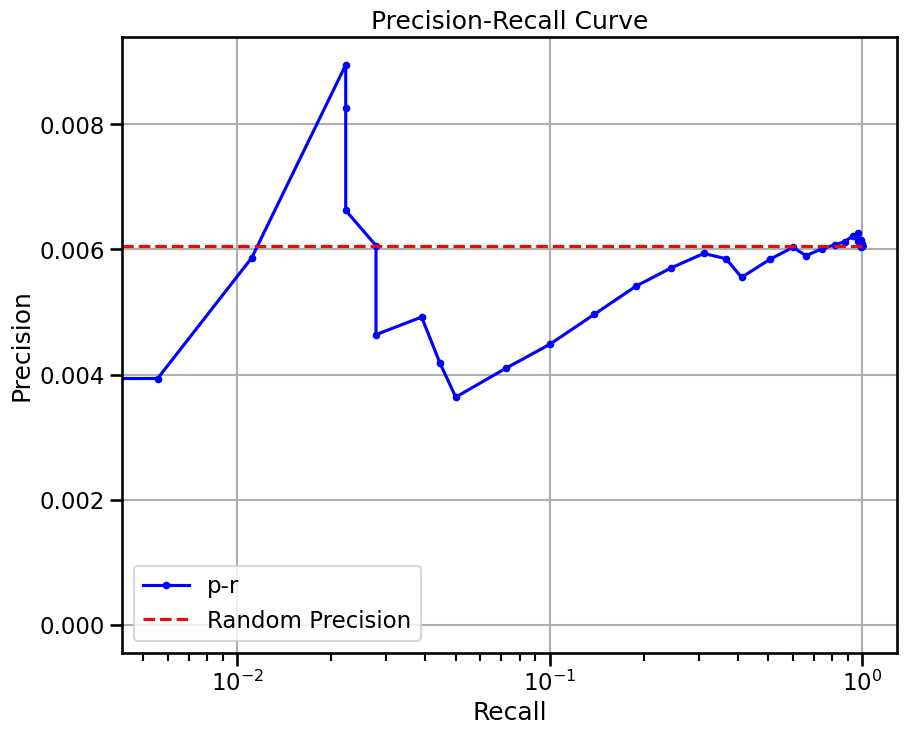

{'precision': 0.006052047609441194,
 'recall': 1.0,
 'rand_precision': 0.006053268765133172,
 'auprc': 0.005705009776771963,
 'EPR': 0.0}

In [16]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

# semrau / all


In [17]:
preadata = get_sroy_gt(get="semrau", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 384 renamining
filtered out 0 cells, 384 renamining
Removed 0 genes.
startin QC
Seeing 35 outliers (9.11% of total dataset):
done


(GRnnData object with n_obs × n_vars = 384 × 10243
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 4404 elements,
 38)

/tmp/ipykernel_1455512/2275473292.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 9459


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.011163604969063264 
recall:  1.0 
random precision: 0.01116507765185585


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:675: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 1493.96it/s]


Area Under Precision-Recall Curve (AUPRC):  0.009831308739476075
EPR: 0.379491440414556


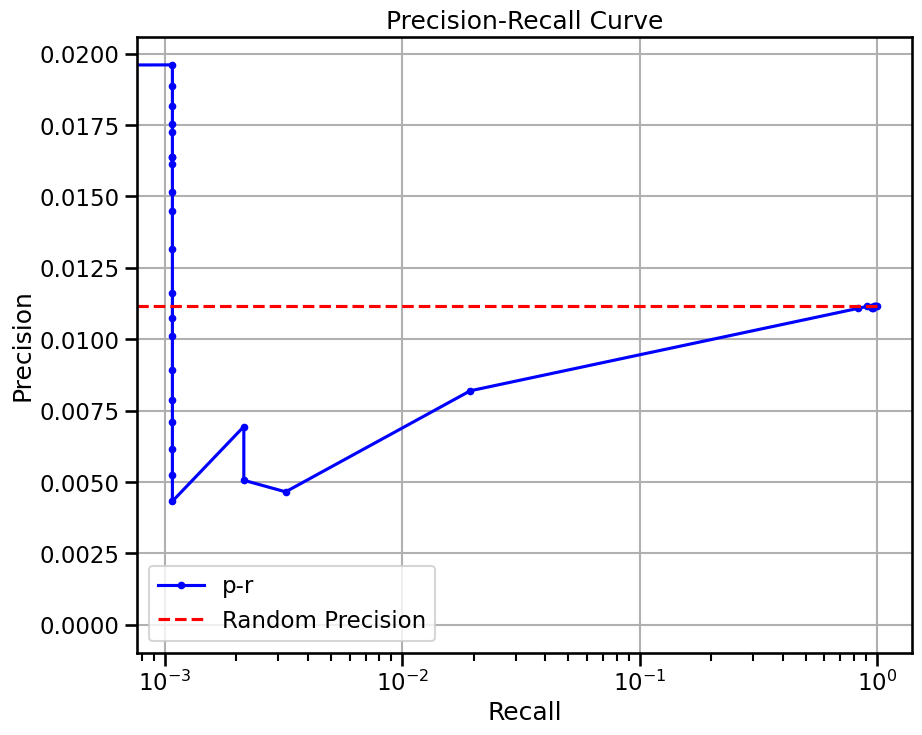

pred shape (17, 4906, 32)
true elem 931 ...
doing regression....
metrics {'used_heads': 3, 'precision': 0.004488530263315688, 'random_precision': 0.0044876845603096845, 'recall': 1.0, 'predicted_true': 58371.0, 'number_of_true': 262.0, 'epr': 3.4770746950303466}


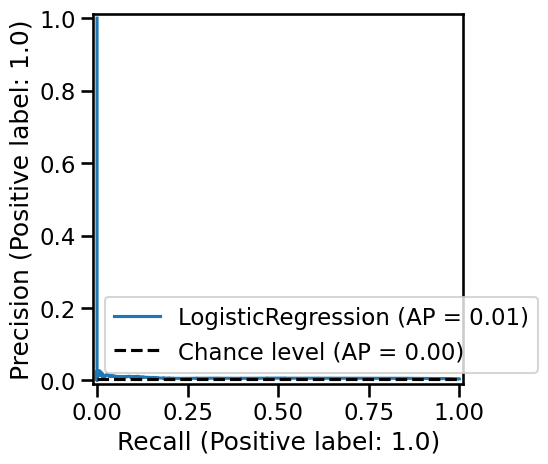

precision:  0.011162801851274549 
recall:  1.0 
random precision: 0.01116507765185585


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 3336.89it/s]


Area Under Precision-Recall Curve (AUPRC):  0.023538495734023224
EPR: 2.48368736264004


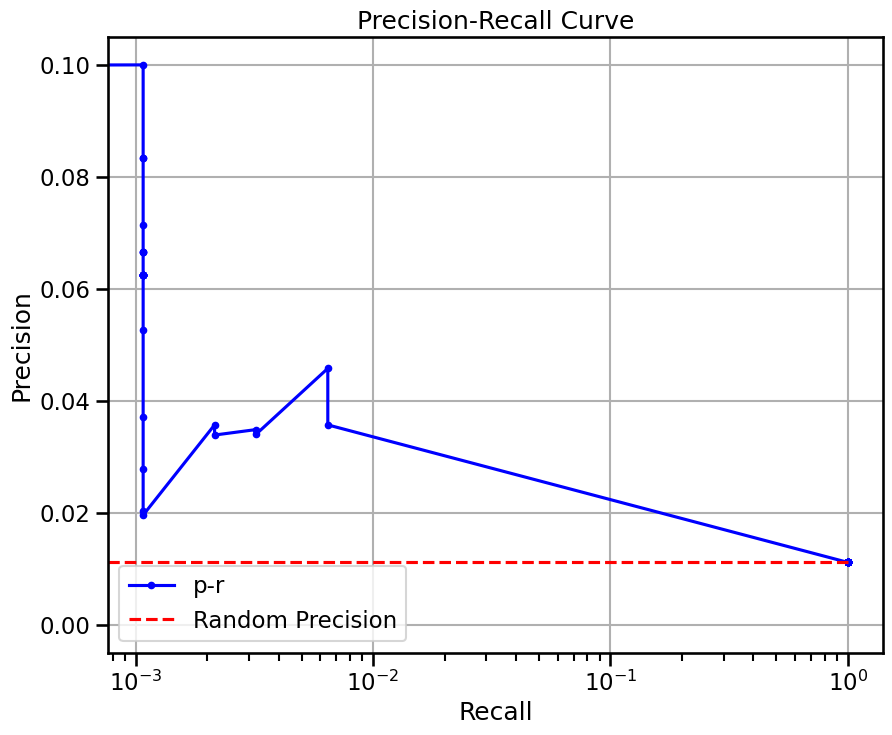

{'precision': 0.011162801851274549,
 'recall': 1.0,
 'rand_precision': 0.01116507765185585,
 'auprc': 0.023538495734023224,
 'EPR': 2.48368736264004}

In [20]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.varp["classified"] = clf_omni.predict_proba(
    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.5, train_size=0.5, class_weight={
                             1: 40, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

/tmp/ipykernel_1455512/590398501.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 9459


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 24147396, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.011162801851274549 
recall:  1.0 
random precision: 0.01116507765185585


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 2877.79it/s]


Area Under Precision-Recall Curve (AUPRC):  0.012375446817455012
EPR: 1.059633742911153


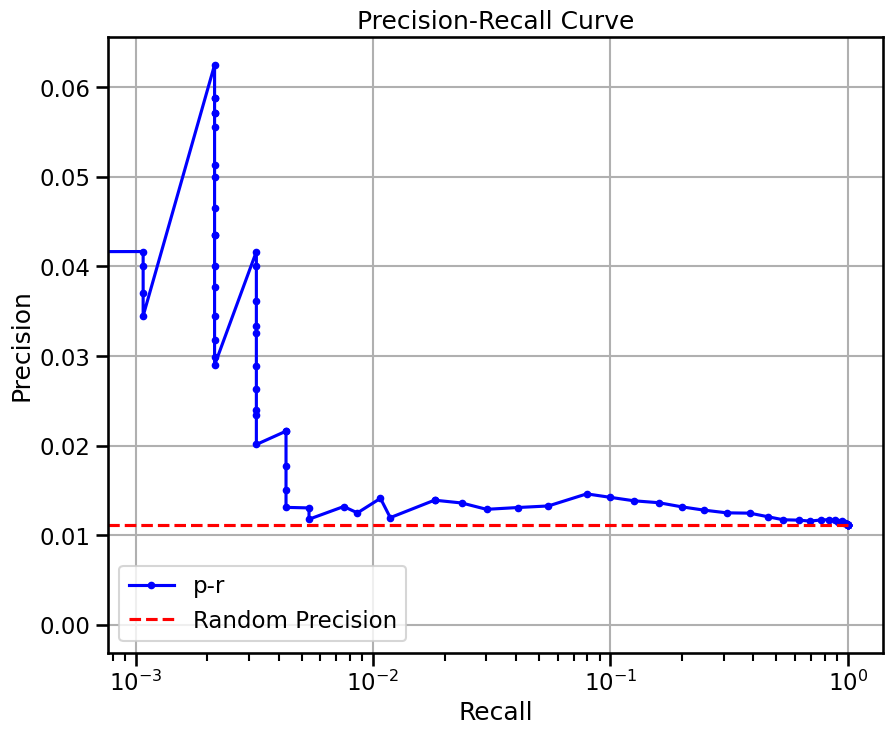

{'precision': 0.011162801851274549,
 'recall': 1.0,
 'rand_precision': 0.01116507765185585,
 'auprc': 0.012375446817455012,
 'EPR': 1.059633742911153}

In [21]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

# semrau / chip


In [13]:
preadata = get_sroy_gt(get="semrau", species="mouse", gt="chip")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 384 renamining
filtered out 0 cells, 384 renamining
Removed 0 genes.
startin QC
Seeing 35 outliers (9.11% of total dataset):
done


(GRnnData object with n_obs × n_vars = 384 × 10243
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 94145 elements,
 49)

/tmp/ipykernel_1486605/1583948291.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 9459


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.23262735185600425 
recall:  0.999868576685504 
random precision: 0.23269113149847095


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:675: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 47%|████▋     | 47/99 [00:00<00:00, 468.88it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 545.56it/s]


Area Under Precision-Recall Curve (AUPRC):  0.22676660213126656
EPR: 1.1495841550037906


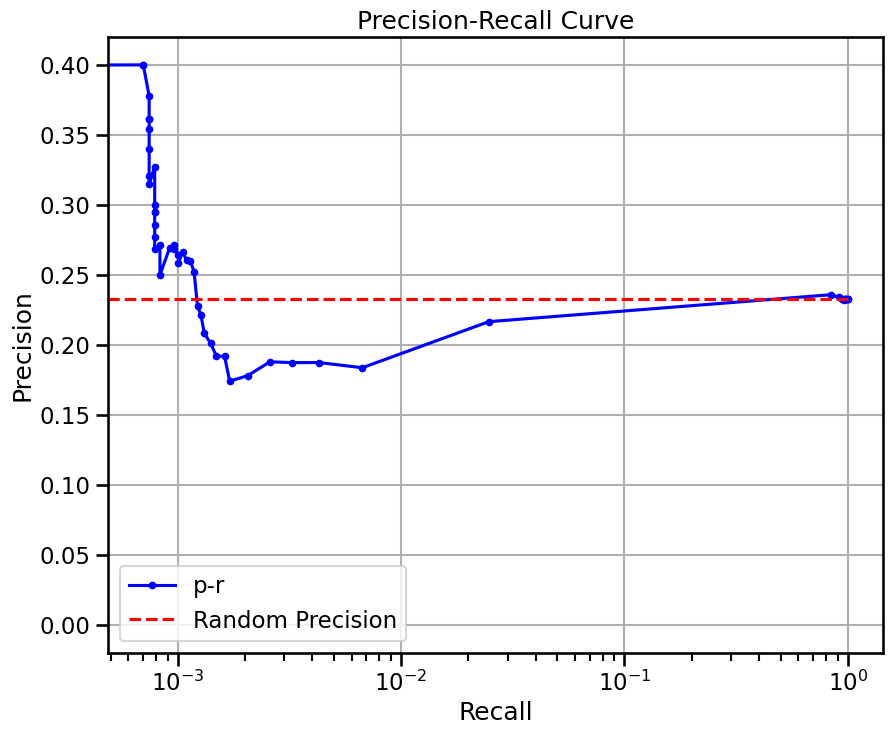

pred shape (20, 4906, 32)
true elem 22827 ...
doing regression....
metrics {'used_heads': 4, 'precision': 0.15167142274765594, 'random_precision': 0.15167142274765594, 'recall': 1.0, 'predicted_true': 49060.0, 'number_of_true': 7441.0, 'epr': 1.1093674557715698}


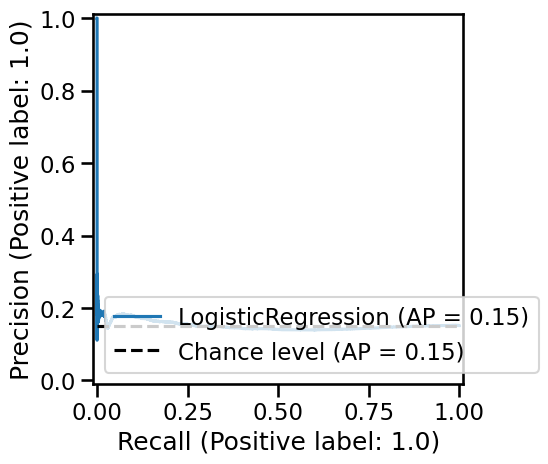

precision:  0.23264370158988992 
recall:  1.0 
random precision: 0.23269113149847095


 73%|███████▎  | 72/99 [00:00<00:00, 717.41it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 736.80it/s]


Area Under Precision-Recall Curve (AUPRC):  0.2778923680768983
EPR: 0.9199868092750005


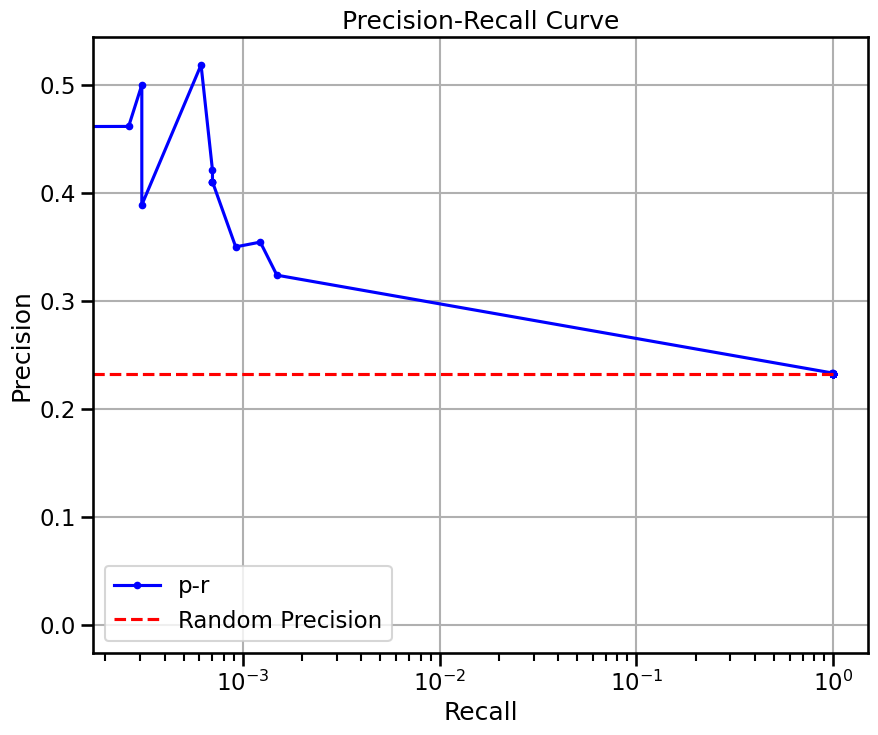

{'precision': 0.23264370158988992,
 'recall': 1.0,
 'rand_precision': 0.23269113149847095,
 'auprc': 0.2778923680768983,
 'EPR': 0.9199868092750005}

In [14]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.varp["classified"] = clf_omni.predict_proba(
    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.5, train_size=0.5, class_weight={
                             1: 40, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

/tmp/ipykernel_1455512/590398501.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 9459


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 24147396, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.23264370158988992 
recall:  1.0 
random precision: 0.23269113149847095


 64%|██████▎   | 63/99 [00:00<00:00, 626.42it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 650.97it/s]


Area Under Precision-Recall Curve (AUPRC):  0.23189476380859955
EPR: 0.9529574608865551


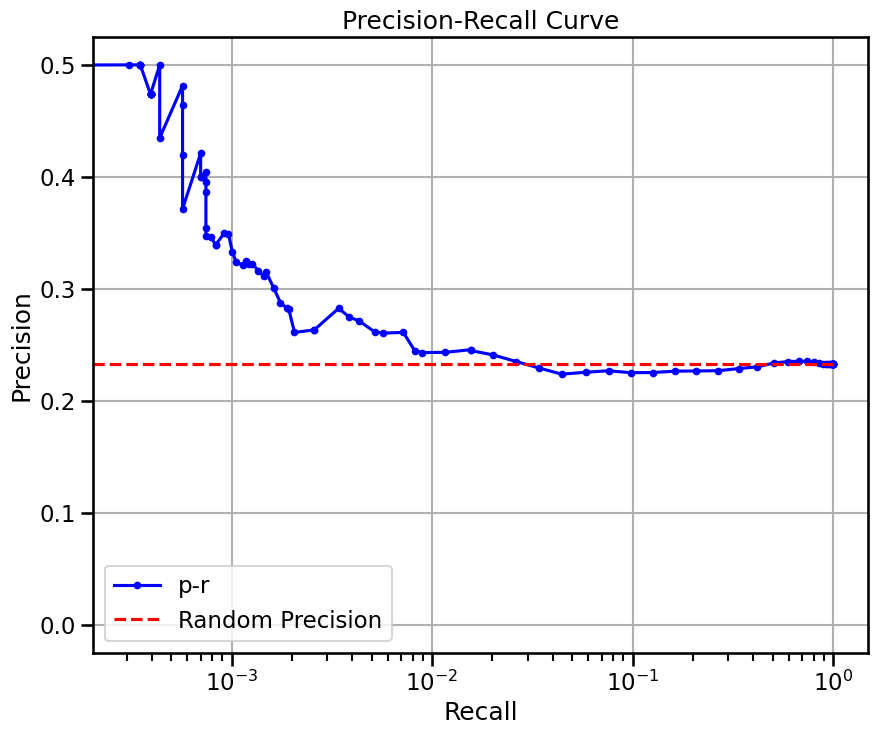

{'precision': 0.23264370158988992,
 'recall': 1.0,
 'rand_precision': 0.23269113149847095,
 'auprc': 0.23189476380859955,
 'EPR': 0.9529574608865551}

In [25]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

# semrau / ko


In [26]:
preadata = get_sroy_gt(get="semrau", species="mouse", gt="ko")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 384 renamining
filtered out 0 cells, 384 renamining
Removed 0 genes.
startin QC
Seeing 35 outliers (9.11% of total dataset):
done


(GRnnData object with n_obs × n_vars = 384 × 10243
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 39782 elements,
 125)

In [15]:
import joblib

In [16]:
clf = joblib.load('/tmp/classifier.pkl')

/tmp/ipykernel_1455512/2725712659.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 9459


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.03119419354468249 
recall:  1.0 
random precision: 0.03119840346872263


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:675: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 756.33it/s]


Area Under Precision-Recall Curve (AUPRC):  0.030679908651916516
EPR: 0.95933128827225


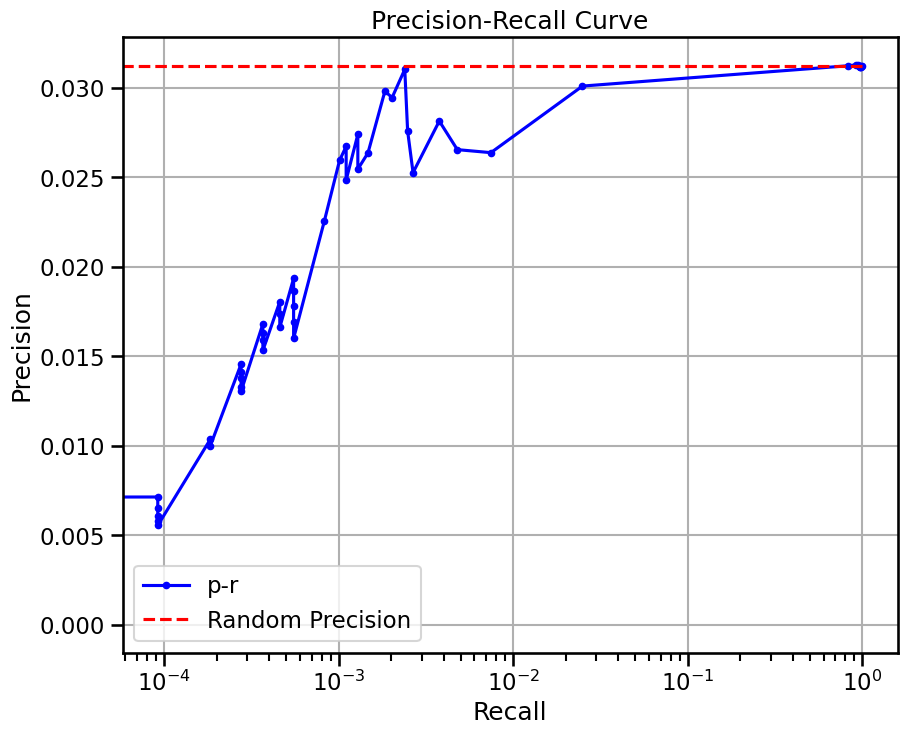

pred shape (71, 4906, 32)
true elem 10865 ...
doing regression....
metrics {'used_heads': 10, 'precision': 0.024623464984111113, 'random_precision': 0.024620614022496167, 'recall': 0.9993003731343284, 'predicted_true': 174021.0, 'number_of_true': 4288.0, 'epr': 1.3381924609803266}


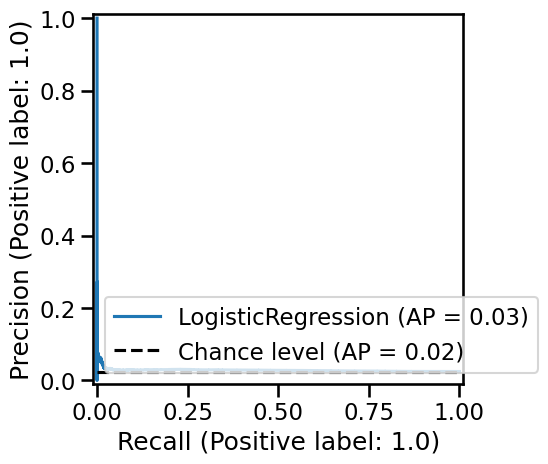

precision:  0.031192044234424073 
recall:  1.0 
random precision: 0.03119840346872263


 94%|█████████▍| 93/99 [00:00<00:00, 474.40it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 453.35it/s]


Area Under Precision-Recall Curve (AUPRC):  0.04664458021867715
EPR: 1.190853229747904


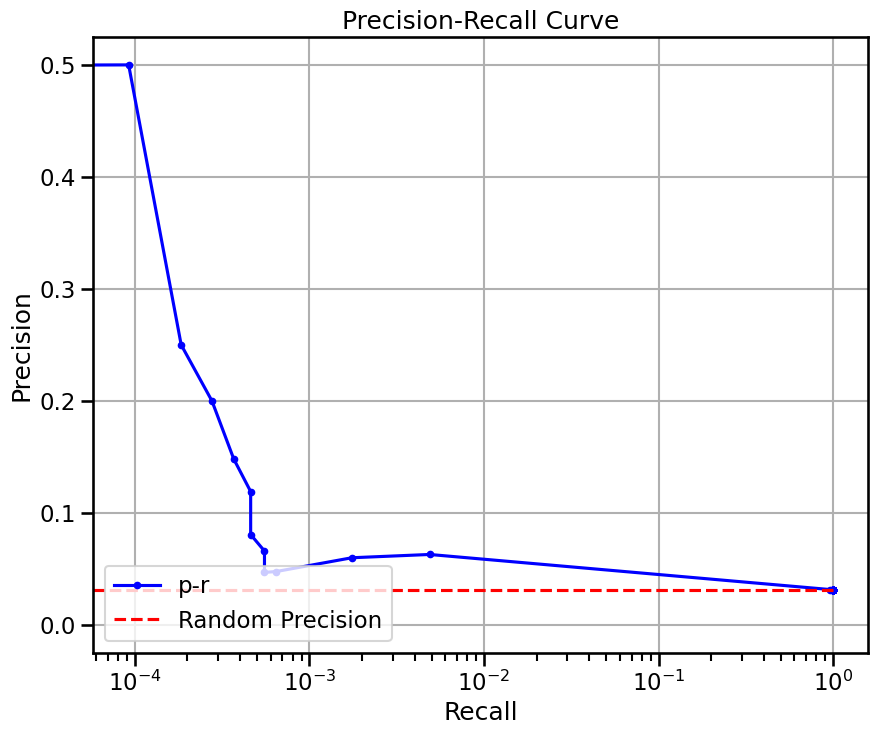

{'precision': 0.031192044234424073,
 'recall': 1.0,
 'rand_precision': 0.03119840346872263,
 'auprc': 0.04664458021867715,
 'EPR': 1.190853229747904}

In [27]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.varp["classified"] = clf_omni.predict_proba(
    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.5, train_size=0.5, class_weight={
                             1: 40, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

/tmp/ipykernel_1455512/590398501.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 9459


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 24147396, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.031192044234424073 
recall:  1.0 
random precision: 0.03119840346872263


 48%|████▊     | 48/99 [00:00<00:00, 474.67it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 527.69it/s]


Area Under Precision-Recall Curve (AUPRC):  0.030854789771348194
EPR: 1.1204012133150174


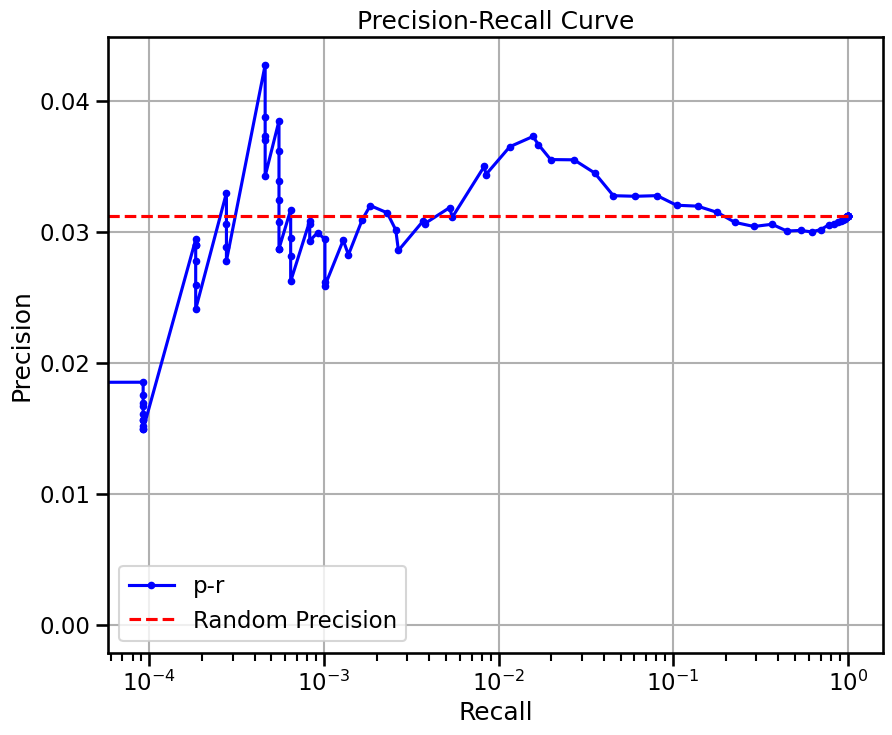

{'precision': 0.031192044234424073,
 'recall': 1.0,
 'rand_precision': 0.03119840346872263,
 'auprc': 0.030854789771348194,
 'EPR': 1.1204012133150174}

In [28]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)